## Neuroevolution DNA Sequence Comparison Using GA Trained Recurrent Neural Network
__October, 2018 - Christopher Sanchez__ 

A neuroevolution model will be created in order to compare DNA sequences. A genetic algorithm will be used to train a recurrent neural network to best determine similarity between sequences. The genetic algorithm will be utilized to determine the best weighting of the networks. The goal today is for the network to be effective at predicting similarity in order to infer homology. If the original genetic algorithm trained model is inefficient, then a backpropagation recurrent neural network model will be created. A final accuracy rate of 98%+ will be considered success.

Deoxyribonucleic acid, or DNA is a double helix shaped structure consisting of a chain of nucleotides known as basepairs that act like a blueprint, providing a list of instructions for your body to produce proteins. There are four distinct bases A, T, C and G. A always bonds with T and C always bonds with G. A wide variety of information can be gained from DNA analysis. It is possible to determine gender, disease susceptibility, familial ties, solve crime, and more! There are multiple sequencing techniques out there, but not all are great for common errors that can occur such as basepairs deletions and insertions. A human genome consists of six billion basepairs mistakes are going to be made. It isn't uncommon for a basepair to get switched around. It is important to use a technique that can operate quickly and accurately. I was inspired by this paper: https://www.cse.unr.edu/~cheung/neorgene.pdf, to attempt improving the dna sequencing techniques that are used today. There will be one human gene used for training which is LOCUS NT_187300, and is 156,246 base pairs long. The gene is the first gene located in chromosome 21. 

Genetic algorithms work by immitating Darwin's survival of the fittest theory. The survival of the fittest theory suggests that natural selection selects the best individuals and discards the weakest, thereby passing on only the strongest genes. Each sample is considered an individual. A population is all of the individuals together. A fitness score is used to determine how fit or weak an individual is. The best parents are used to breed and create individuals with characteristics of the parents. A mutation can be added to further improve on results. Finally evolution takes place combining all of the steps together to create the best offspring possible.

Combining recurrent neural networks and a genetic algorithm is a quite interesting way to train the network. First the dna sequence must be cleaned and processed in order to be passed into the neural network. Once the sequence is processed and split into individuals the genetic algorithm will pass the individuals into the neural network using a custom fitness score in order to provide a grade to for network. Then the data will be bred and mutated in order to produce offspring and cause evolution.

### Introduction:

To solve the problem of DNA sequence similarity comparison, two different splits of gene LOCUS NT_187300 will be taken and used for comparison to train the model. Basepairs are considered similar if the two genes being compared are the same. The dna sequence will be cleaned and processed to pass into a population of recurrent neural networks. The neural networks will be trained using a genetic algorithm to manipulate the weights from the weakest population based on previous high performing weights from the fittest population. The weights will be determined via crossover and mutation. Each neural network in the population will represent and individual. All of the individuals will be trained using a training split, and tested using a test split. 

After the evolution of the population, the top network will be taken for further testing. It will be tested against four generated sequences with similarities of 0%, 33%, 66%, and 100%. These sequences will provide a good basis for how the model is performing. 

In [1]:
import numpy as np
import pandas as pd
import re
import random
import time
from IPython.display import clear_output
from numpy import argmax, array
from collections import Counter

import matplotlib.pyplot as plt
import keras
import tensorflow
# Import various componenets for model building
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Input, TimeDistributed, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import bernoulli
# Import the backend
from keras import backend as K


/Users/c/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/c/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Mean squared error sums the distance of all the points squared from the regression line fitting the data. Sklearns mean squared error function is used in order to generate the MSE which will be returned and utilized as the fitness score for the genetic algorithm. The data will also be reshaped into two dimensions from three in order to pass into the function properly.

In [2]:
def mse(y_true, y_pred):
    # reshape data in order to be passed into the mean squared error function
    y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
    #calculate the mean squared error
    mse = mean_squared_error(y_true, y_pred)
    return mse

The various sequences will be visualized using bargraphs. These two functions will allow for easy and clean displaying of the data. The first function plots one set of data, while the second function allows for comparisons between data.

In [3]:
def basepair_graph(data):
    # get a count of each basepair
    character_count = Counter(data)
    print(character_count)
    # create the labels and values
    labels, values = zip(*character_count.items())
    
    # create the index values
    indexes = np.arange(len(labels))
    # set the width of the bars
    width = .8
    
    # create bar plot
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0, labels)
    plt.title('Count of Basepairs')
    plt.xlabel('Basepairs')
    plt.ylabel('Count')
    plt.show()

def basepair_graph_comparison(sequence_one, sequence_two, width, ax=None):
    # get a count of each basepair for each sequence
    sequence_one_count = Counter(sequence_one)
    sequence_two_count = Counter(sequence_two)

    # create the labels and values
    labels_one, values_one = zip(*sequence_one_count.items())
    labels_two, values_two = zip(*sequence_two_count.items())

    # create the index values
    indexes = np.arange(len(labels_one))
    
    # create bar plot
    ax.bar(indexes, values_one, width);
    ax.bar(indexes, values_two, width * .5);
    plt.xticks(indexes + width * 0, labels_one)

The graph average output function will make it easy to plot the performance of the top model, by visualizing the average output for each possible combination of sequences being compared.

In [4]:
def graph_average_output(model):
    
    # all possible combinations of sequences
    possible_combinations = [('G', 'A'), ('G', 'C'), ('G', 'T'), ('G', 'G'), 
                             ('A', 'C'), ('A', 'T'), ('A', 'G'), ('A', 'A'), 
                             ('C', 'A'), ('C', 'T'), ('C', 'C'), ('C', 'G'), 
                             ('T', 'A'), ('T', 'C'), ('T', 'G'), ('T', 'T')]

    # Loop through the possible combinations and determine
    # mean output for each
    combos = []
    for x in possible_combinations:
        sequence_one = x[0] * 50
        sequence_two = x[1] * 50
        cominations, validate = create_dna_array(sequence_one, sequence_two, 50)
        y_pred = model.predict(cominations)
        pred_mean = np.mean(y_pred)
        round_mean = round(pred_mean, 2)
        combos.append(round_mean)

    # plot the mean outputs
    plt.figure(figsize=(10,5))
    plot_combos = plt.plot(combos, 'ko')
    plt.title('Output Per Combination')
    plt.xlabel('Combinations')
    plt.ylabel('Output')
    plt.xticks(np.arange(16), ([x[0] + x[1] for x in possible_combinations]))
    combos_coordinates = plot_combos[0].get_data()
    x = [x for x in combos_coordinates[0]]    
    y = [y for y in combos_coordinates[1]]   
    
    # annotate the points with the output score
    for i in range(len(combos)):
        plt.annotate(str(combos[i]), (x[i], y[i]))

    plt.show()

### I: Importing and analyzing data
LOCUS NT_187300 will be imported from a text file as a string. After it is imported it will be assigned to the variable dna_basepairs. It will be cleaned by removing all of the numbers, new lines and white spaces. The sequence will then be visualized using the previously created basepair_graph function to demonstrate the distribution of the 156,246 basepairs.

Counter({'C': 44559, 'G': 42681, 'A': 36681, 'T': 32325})


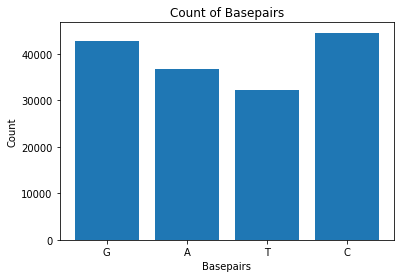

In [5]:
with open('dna.txt', 'r') as myfile:
  dna_basepairs = myfile.read()
dna_basepairs = re.sub(r'[0-9]([0-9])?([0-9])?([0-9])?([0-9])?([0-9])?', '', dna_basepairs)
dna_basepairs = re.sub(r'\n', '', dna_basepairs)
dna_basepairs = re.sub(r'\s+', '', dna_basepairs).strip().upper()
# graph basepairs
basepair_graph(dna_basepairs.upper())

It is a non normal and non uniform distribution. C's have the highest amount of basepairs at 44.5k. T's represent the lowest quantity at around 32.3k. 

### II: Processing the Dna Sequence into an array and determining similarity

The two sequences that need to be compared, and the batch size are passed into the create_dna_array function. The batch size of basepairs and samples are calculated in order to properly reshape the data to be passed into the neural networks. An array of zeroes is created to provide an array to be manipulated and allow for vectorization of the base pairs. Vectorization will work by converting A to 1000, T to 0100, G to 0010, and C to 0001. The two sequences will be vectorized and combined in order to be tested for similarity. Finally a similarity score will be awarded to each pair of sequences. 

In [6]:
def create_dna_array(sequence_one, sequence_two, batches):

    # determine number of samples to reshape the data into 3d
    samples = int(len(sequence_one) / batches)
    
    # Create an array of zeros to be filled with vectorized sequences
    array = np.zeros((len(sequence_one), 8))
    # mapping the array with a dictionary to effectively vectorize the basepairs.

    # for the bases in each sequence fill the designated spot in the array of zeroes with a 1.
    for base in range(len(sequence_one)):
        base_one = sequence_one[base]
        base_two = sequence_two[base]
        array[base, vectorize_sequence[base_one]] = 1
        array[base, vectorize_sequence[base_two]  + 4] = 1

    # determine whether sequences are similar or not and label true or false
    similarity_array = np.zeros((len(array), 1))

    for i in range(len(array)):
        if np.equal(array[i][:4], array[i][4:]).all():
            similarity_array[i] = 1
        else:
            similarity_array[i] = 0 
            
    return [np.asarray(array).reshape(samples, batches, 8), 
            similarity_array.reshape(samples, batches, 1)]

### III: Creating the population of LSTM networks

30 LSTM networks, which will be considered the individuals in this test, will be created as the population. The network consists of three layers. The first which is the input layer, contains 8 input nodes, four for each sequence, an LSTM layer with x nodes, and a third dense layer as the output layer with 1 node. A tanh function will be used which will give an output between -0.9 and 0.9. 0.9 will be interpreted as having a very high similarity and -0.9 will be the inverse. Bias will also be used. 

In [7]:
# comparison is used to pass in the shape of the data being compared
# amount is the amount of networks to be created.

def create_population(comparison, amount):
    network_population = []
    # create the specified amount of individual neural networks
    # using a tanh activation function
    for i in range(amount):
        model = Sequential()
        # add Long short term memory RNN layer using bias
        model.add(LSTM(88, 
                       input_shape=(comparison.shape[1], 8), 
                       activation='tanh', 
                       return_sequences=True, 
                       use_bias=True))
        
        # add a 10% dropout rate to help with overfitting
        model.add(Dropout(0.1))

        # add a dense layer as the output layer using bias
        model.add(Dense(1, 
                        activation='tanh', 
                        use_bias=True))
        
        # append the individual to the population 
        network_population.append(model)
    return network_population

### IV: Grading the population:

The grading function is used to define the fitness score and grade the networks in order to sort the fittest individuals from the weakest. If the output is greater than 0.5 or less than -0.5 then a point is awarded to the fitness score of the individual being tested. After all of the networks have been tested and assessed a fitness score, they will be sorted into fittest and weakest populations.

In [8]:
def grade(pop, inputs, labels):
    # determine the fitness score for each individual in the population
    fitness = []
    for i in pop:
        # make a prediction with each individual
        y_pred = i.predict(inputs)
        # keep track of fitness score for each individual
        fitness_score = 0
        y = []
        # score the outputs
        for layer in y_pred:
            for output in layer:
                if (output >= 0.5) or (output <= -0.5):
                    fitness_score += 1
        fitness.append(fitness_score)

    mse_vec = np.asarray(fitness)

    # arg sort fitness and separate the fittest networks from the weakest.
    sorted_mse_idx = np.argsort(mse_vec)
    sorted_mse_idx = sorted_mse_idx[::-1]
    
    fittest_mse = sorted_mse_idx[:9]
    weakest_mse = sorted_mse_idx[9:]
    
    # separate the fittest individuals from the weakest.
    fittest_models = []
    weakest_models = []

    for model in fittest_mse:
        fittest_models.append(pop[model])
    for model in weakest_mse:
        weakest_models.append(pop[model])
        
    return [fittest_models, weakest_models]

### V: Crossover and Mutate



In natural reproduction genes are passed on from parents to offspring. The crossover function is used to simulate this natural function. The fittest models will be bred, or crossed over to the weakest models, elimating some of the weaker genes with stronger genes. First the weights are retreived from the model being tested. Then a random bernoulli distribution will be generated at a predesignated rate. Next, the weights from the fittest individual, based on the position of 1's in the bernoulli distribution, will replace the weights in the weakest individual at the same position. Finally the new weights will be set and the crossover will have been completed.

In [9]:
def crossover(fittest, weakest):
    # get weights
    fittest_weights = fittest.get_weights()
    weakest_weights = weakest.get_weights()

    # crossover the weights from the fittest networks to the weakest
    counter = 0
    for layer in weakest_weights:
        select_weights = bernoulli.rvs(p=0.5, 
                                       size=layer.shape)
        fit_weights = fittest_weights[counter]
        layer[select_weights==1] = fit_weights[select_weights==1] * select_weights[select_weights==1]
        counter += 1
    # set the new weights
    weakest.set_weights(weakest_weights)


Mutations naturally occur in the wild. They can be beneficial or deterimental. There are some mutations that can cause immunity to certain diseases, and there are some mutations that cause diseases. The mutate function will be used to add some variation to the previous networks by randomly selecting weights from the individuals based on a bernoulli distribution and summing them with value from a generated gaussian distribution.

In [10]:
def mutate(network):
    # get weights of the fittest and weakest networks

    weights = network.get_weights()

    # add a random value from a gaussian distributions to the previous weights
    for layer in weights:
        select_weights = bernoulli.rvs(p=0.5, size=layer.shape)
        random_numbers = np.random.normal(0, 1, layer.shape)
        layer[select_weights==1] = random_numbers[select_weights==1] + layer[select_weights==1]

    # set the new weights
    network.set_weights(weights)


### VI Breeding

The breeding process is where everything starts to come to life. The crossover will be performed creating new child networks that will then be mutated. After they have been crossed over and mutated the population will be created using the new children.

In [11]:
def breed(fittest, weakest, mutation=True):
    for weakest_model in weakest:
        # crossover the fittest and weakest individuals
        fittest_model = np.random.choice(fittest)
        crossover(fittest_model, weakest_model)
    network_pop = fittest + weakest
    
    # mutate the individuals in the population
    if mutation == True:
        for network in network_pop:
            # add or subtract weight from a gaussian distribution
            mutate(network)    
    return network_pop

### VII: Evolve

In order to perform evolution, ultimately running the genetic algorithm, evolution must take place. In order to perform evolution several steps must take place.
- Load the DNA sequences for comparison
- Split into train and test sets
- Load the initial network population
- Grade and breed the population
- Validate the top individual of each epoch in order to preserve top models
- Visualize the results to determine how the top individal fits

Epoch: 30 Time: 29.430255889892578 Mean Squared Error: 0.7641517032216403 Fittest so far: 0.7255833802020946


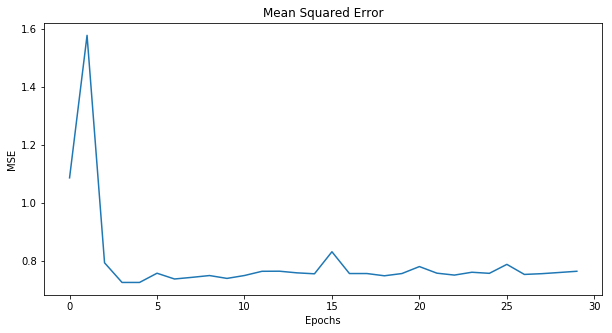

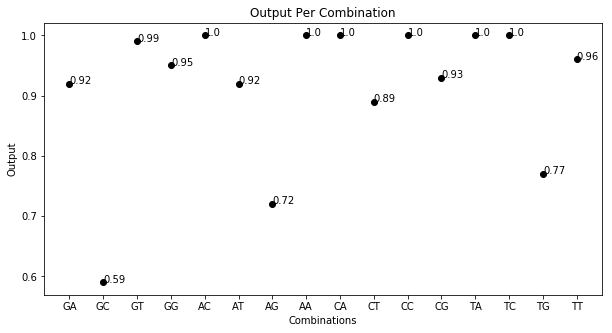

Total time to run: 0.263311254647043


In [12]:
# set the network population to the original generated network population
network_population = []
graph_mse = []
top_individual = []
previous_mse = 0
total_time_start = time.time()
for epoch in range(30):
    start_epoch_time = time.time()
    
    # create the initial population
    if epoch == 0:
        comparison, similarity_array = create_dna_array(dna_basepairs[:150000], 
                                                        dna_basepairs[5000:155000], 
                                                        50)
        comparison = keras.utils.normalize(comparison, axis=1, order=2)
        X_train, X_test, y_train, y_test = train_test_split(comparison, 
                                                            similarity_array, 
                                                            test_size = 0.20, 
                                                            random_state = 36)
        network_population = create_population(comparison, 30)

    # grade the network population and breed it
    grade_network = grade(network_population, X_train, y_train)
    if epoch % 5 != 0:
        breed_networks = breed(grade_network[0], grade_network[1], False)
    else:
        breed_networks = breed(grade_network[0], grade_network[1], True)

    # set the network population to the new offspring
    network_population = breed_networks
    
    # validate the network against the test data.
    y_pred = network_population[0].predict(X_test)
    m_s_e = mse(y_test, y_pred)

    if epoch == 0:
        previous_mse = m_s_e
        top_individual = network_population[0]

    elif m_s_e <= previous_mse and epoch != 0:
        previous_mse = m_s_e
        top_individual = network_population[0]
    network_population[0].set_weights(top_individual.get_weights())
    graph_mse.append(m_s_e)
    clear_output()
    
    stop_epoch_time = time.time()
    epoch_duration = stop_epoch_time-start_epoch_time
    print('Epoch:', epoch + 1, 
          'Time:', epoch_duration, 
          'Mean Squared Error:', m_s_e, 
          'Fittest so far:', previous_mse)

            # update the graph of MSE's for each epoch
    plt.figure(figsize=(10,5))
    plt.plot(graph_mse)
    plt.title('Mean Squared Error')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.show()
    
total_time_end = time.time()
total_time = total_time_end-total_time_start

# graph the output similarity of the top network.
graph_average_output(network_population[0])

print('Total time to run:', (total_time / 60) / 60)

Unfortunately the model is overfitting and isn't separating the sequence comparisons very well. The similar outputs should be greater than zero while the disimilar outputs should be less than 0, however with the top individual the outputs are scattered, with no real pattern.

Due the the GA not fitting the data well, a new network will be created using the standard back propagation. Back propagation works by going backwards through the layers and adjusting the weights based on the weighted error of the previous forward propagation. The same layers will be used, except this time loss, optimization and metric functions will be added.

In [13]:
model = Sequential()
        # add Long short term memory RNN layer using bias
model.add(LSTM(88, 
               input_shape=(X_train.shape[1], 8), 
               activation='tanh', 
               return_sequences=True, 
               use_bias=True))

# add a 10% dropout rate to help with overfitting
model.add(Dropout(0.1))


# add a dense layer as the output layer using bias
model.add(Dense(1, 
                activation='tanh', 
                use_bias=True))
# use binary crossentropy as the loss function, and adam as the optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], verbose)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 50, 88)            34144     
_________________________________________________________________
dropout_31 (Dropout)         (None, 50, 88)            0         
_________________________________________________________________
dense_31 (Dense)             (None, 50, 1)             89        
Total params: 34,233
Trainable params: 34,233
Non-trainable params: 0
_________________________________________________________________
None


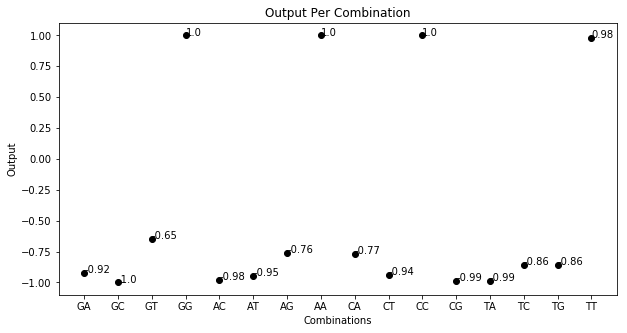

In [14]:
# train the Network.
model.fit(X_train, y_train, batch_size=30, epochs=30, verbose=0, validation_data=(X_test, y_test))

# visualize how well the network is fitting
graph_average_output(model)

The backpropagation model is working wonderfully! It clearly separated the similar and disimilar pairs. The new model will now represent the top individual.

### VIII: Creating sequences for testing.

In order to further test the individual a function will be implemented to create sequences with a specified rate of similarity. Four sequences will then be created for testing. The first sequence will be completely the same. The function will match up basepairs at a rate of 0%. After that a sequence will be created to reflect a 33% rate of similarity. Next up is a sequence that's 66% similar. The final sequence will be completely different with a similarity of 100%.

In [15]:
def create_sequences(size, difference):
    sequence_one = []
    sequence_two = []
    # create same sequences
    if  difference == 0:       
        for x in range(size):
            basepairs = ['A', 'T', 'G', 'C']
            choice = np.random.choice(basepairs)
            sequence_one.append(choice)
            sequence_two.append(choice)
        sequence_one = str(''.join(sequence_one))
        sequence_two = str(''.join(sequence_two))
        
    # create completely different sequences
    elif difference == 100:
        for x in range(size):
            basepairs = ['A', 'T', 'G', 'C']
            choice = np.random.choice(basepairs, p=[.27, .40, .10, .23])
            sequence_one.append(np.random.choice(basepairs))

            basepairs.remove(sequence_one[x]) 
            sequence_two.append(np.random.choice(basepairs, p=[.23, .33, .44]))
        sequence_one = str(''.join(sequence_one))
        sequence_two = str(''.join(sequence_two))
        
    # create sequences with certain similarity.
    else:
        split = int(round(size * difference))
        for x in range(split):
            basepairs = ['A', 'T', 'G', 'C']
            choice = np.random.choice(basepairs)
            sequence_one.append(choice)
            sequence_two.append(choice)
            
        for x in range(split, size):
            basepairs = ['A', 'T', 'G', 'C']
            choice = np.random.choice(basepairs)
            sequence_one.append(np.random.choice(basepairs, p=[.32, .28, .17, .23]))

            basepairs.remove(sequence_one[x])
            sequence_two.append(np.random.choice(basepairs, p=[.33, .33, .34]))
        
        sequence_one = str(''.join(sequence_one))
        sequence_two = str(''.join(sequence_two))

    return sequence_one, sequence_two

# 100% similar
simliarity_100, labels_100 = create_sequences(100000, 0)
# 33% similar
simliarity_33, labels_33 = create_sequences(100000, 0.33)
# 66% similar
simliarity_66, labels_66 = create_sequences(100000, 0.66)
# 0% similar
simliarity_0, labels_0 = create_sequences(100000, 100)

### IX: Processing the data for testing

The newly created data will be passed into the create_dna_array function which will vectorize the sequences, shuffle them and mark the similar and disimilar basepairs. The inputs and outputs will be saved in lists for easy access.

In [16]:
# create the test sequence comparisons
compare_same, same_labels = create_dna_array(simliarity_100, labels_100, 50)
compare_third, third_labels = create_dna_array(simliarity_33, labels_33, 50)
compare_two_thirds, two_thirds_labels = create_dna_array(simliarity_66, labels_66, 50)
compare_different, no_similarity_labels = create_dna_array(simliarity_0, labels_0, 50)

# add all the comparison arrays together
comparison_tests = [compare_different, 
                    compare_third, 
                    compare_two_thirds,
                    compare_same]

# add the labels together
similarity_labels = [no_similarity_labels, 
                    third_labels, 
                    two_thirds_labels, 
                    same_labels]

Now that the data has been successfully cleaned, processed and sorted, the data will be passed into the created function to graph basepair comparisons, to visualize the distribution of basepairs being compared.

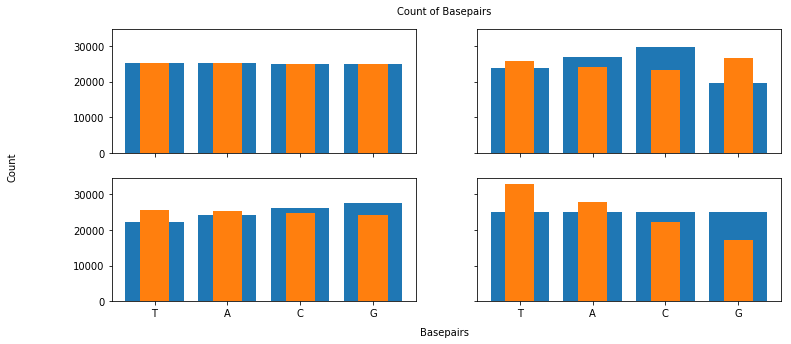

In [17]:
# plot the amount of each basepair in each sequence
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(12,5))
basepair_graph_comparison(simliarity_100, labels_100, .8, ax1)
basepair_graph_comparison(simliarity_33, labels_33, .8, ax2)
basepair_graph_comparison(simliarity_66.upper(), labels_66.upper(), .8, ax3)
basepair_graph_comparison(simliarity_0.upper(), labels_0.upper(), .8, ax4)
# set the title
fig.text(.51, .93, 'Count of Basepairs', ha='center', va='center')
# set x label
fig.text(0.51, 0.04, 'Basepairs', ha='center', va='center')
# set y label
fig.text(0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical')
plt.show()

There are multiple different distributions which will present a challenge for the network to process.

### X: Test the fittest individual:

The outputs of all of the different test sets of data from the fittest individual will be displayed. They should reflect what is already known. If the pairs are similar than the output should be greater than zero, else the output should be less than zero.

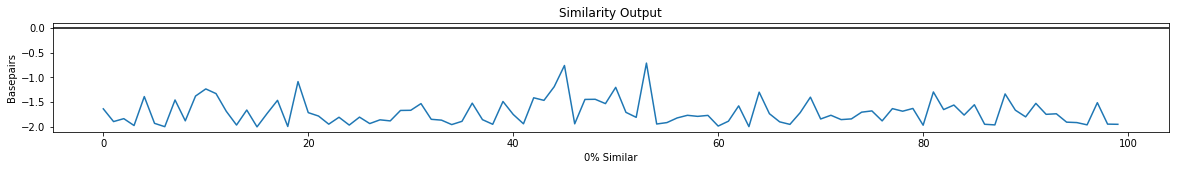

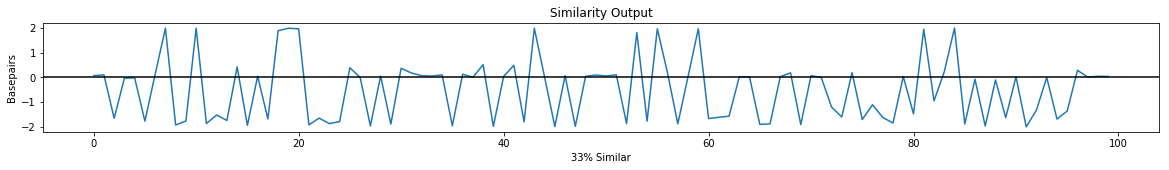

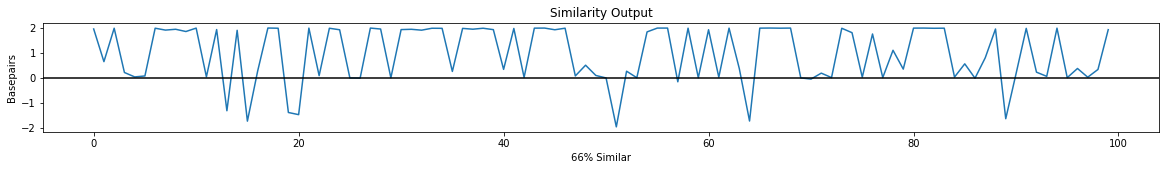

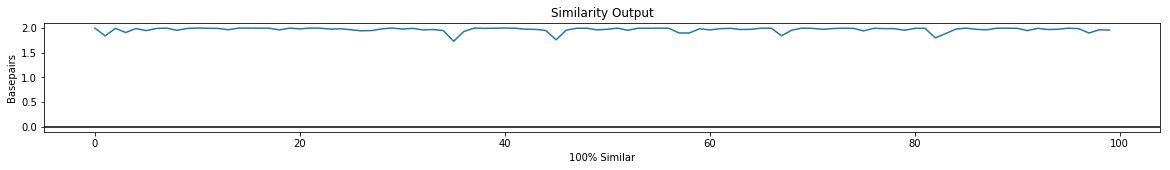

In [18]:
# plot the outputs for all of the networks
similarity_tests = ['0% Similar', '33% Similar', '66% Similar', '100% Similar']
counter = 0
graph_output = []
graph_mse = []
# run the best network on the test data to test for consistency.
for x in range(4):
    y_pred = model.predict(comparison_tests[x])
    graph_output.append(y_pred)

#visualize the outputs
for x in graph_output:
    x = x.reshape(x.shape[0] * x.shape[1], 1)
    np.random.shuffle(x)
    plt.figure(figsize=(20,2))
    plt.plot(x[:100] + x[-100:])
    plt.axhline(0, color='black')

    plt.title('Similarity Output')
    plt.xlabel('{}'.format(similarity_tests[counter]))
    plt.ylabel('Basepairs')
    counter += 1
    plt.show()

The model is fitting great across all various rates of similarity.
- 0% similarity - All of the points are below 0
- 33% similarity - the points range below and above 0
- 66% similarity - as expected it's performing like 33% similarity's
- 100% similarity - all of the points are above 0

The predicted similarity for each test set by the fittest individual will be graphed in order to display the predicted similarity.

In [21]:
y_pred = model.predict(comparison_tests[1])
y = []
for layer in y_pred:
    for output in layer:
        if (output >= 0.0):
            y.append(1)
        else:
            y.append(0)

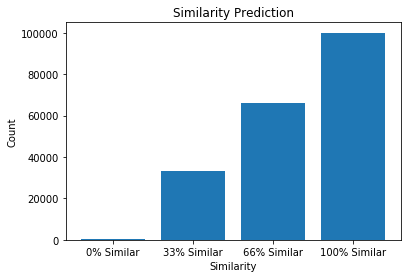

In [19]:
# store output similarity score for visualization
predicted_outputs = []

# run the best network on the test data to test for consistency.
for x in range(4):
    output_true = 0
    y_pred = model.predict(comparison_tests[x])
    y = []
    for layer in y_pred:
        for output in layer:
            if (output >= 0.0):
                output_true += 1
    
    predicted_outputs.append(output_true)
#graph the predicted similarity of the test data
plt.bar(range(len(predicted_outputs)), predicted_outputs, width=0.8, align='edge')
plt.title('Similarity Prediction')
plt.xlabel('Similarity')
plt.ylabel('Count')
plt.xticks(np.arange(4) + 0.4, ('0% Similar', '33% Similar', '66% Similar', '100% Similar'))
plt.show()

The model is working perfectly and has successfully classified all of the test data with perfect accuracy.

### XI: Discussion and Conclusion:

To begin the project several functions were created to assist in making the project cleaner and easier to read, and to construct the genetic algorithm.

__Creating the population__ was done by creating 30 individual neural networks with three layers each. First the input layer which is 8 nodes, followed by the LSTM layer of 88 nodes, and finally the dense output layer of 1 node.

__Grading the population__, assessing the fitness score, and sorting were done by awarding a point to the fitness score for each output that was greater than 0.5 or less than -0.5. Then it was sorted into the 10 fittest and 20 weakest networks.

__Crossover__ was performed by taking half of the weights from a random individual from the fittest population and replacing the weights from the weakest population

__Mutation__ used a gaussian distribution to mutate the 50% of the weights by a value based on a mean of zero and a standard deviation of one.

__Breeding__ utilized crossover and mutation to simulate breeding.

__Evolution__ used all of the previous parts together in order to evolve the network to attempt to create a model that fit well.

The genetic algorithm didn't perform so well, it was quite time intensive, and it had a severe tendency to want to overfit the data. Validating the top individual with an accuracy function rather than MSE might do better.

In order to accomplish the goal of building a recurrent neural network to compare DNA sequences in order to infer homology, a normal backpropagation RNN was created and was used to represent the top individual.

The final individual performed very well. It used the same architecture as the genetic algorithm, but this time included a loss function, optimizer, and scoring metric. The individual was tested on four different sets of created sequences.

- The first set was 0% similar
- The second set was 33% similar
- The third 66% similar
- Finally the fourth set was 100% similar

__OVERALL PERFORMANCE__

The final model fit perfetly. It was able to classify all of the test sets at 100% accuracy. Though the genetic algorithm didn't pan out, the experiment was a success.

__Why not just loop through the sequences to determine similarity?__

Using a LSTM RNN allows for more complex relationships. The network makes it possible to check for relation between neighboring bases, so it would make double checking sequencing easier and accurate.

__In the future__
- Optimize the grading function.
- Determine a better way to validate the performance and cut down on over/underfitting.
- Speed up the algorithm training time.
- Modify the algorithm to allow for sequence detection based on surrounding bases